## Assignment 1b: Time Series Forecasting

### \yuqing chen \a1841612

#### Follow detail instructions in the assignment specification and use these heading for implementation and discussion

### 1. Read the dataset

In [2]:
import pandas as pd
import numpy as np

# load the data from the dataset
df = pd.read_csv('energydata_complete.csv', usecols=['date', 'Appliances'])
# 查看数据集的前几行
print(df.head())

               date  Appliances
0  11/01/2016 17:00          60
1  11/01/2016 17:10          60
2  11/01/2016 17:20          50
3  11/01/2016 17:30          50
4  11/01/2016 17:40          60


/var/folders/n3/ddr1nygd4b11p0zv8kwtqx3w0000gn/T/ipykernel_59223/1196010967.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
print('Number of missing values:', df.isnull().sum())

Number of missing values: date          0
Appliances    0
dtype: int64


In [4]:
df['date'] = pd.to_datetime(df['date'],format='%d/%m/%Y %H:%M')
df.set_index('date', inplace=True)

In [5]:
# 查看数据集的前几行
print(df.head())

                     Appliances
date                           
2016-01-11 17:00:00          60
2016-01-11 17:10:00          60
2016-01-11 17:20:00          50
2016-01-11 17:30:00          50
2016-01-11 17:40:00          60


In [6]:
print(df.tail())

                     Appliances
date                           
2016-05-27 17:20:00         100
2016-05-27 17:30:00          90
2016-05-27 17:40:00         270
2016-05-27 17:50:00         420
2016-05-27 18:00:00         430


In [7]:
df.dtypes

Appliances    int64
dtype: object

### 2. Analyse and visualise the data

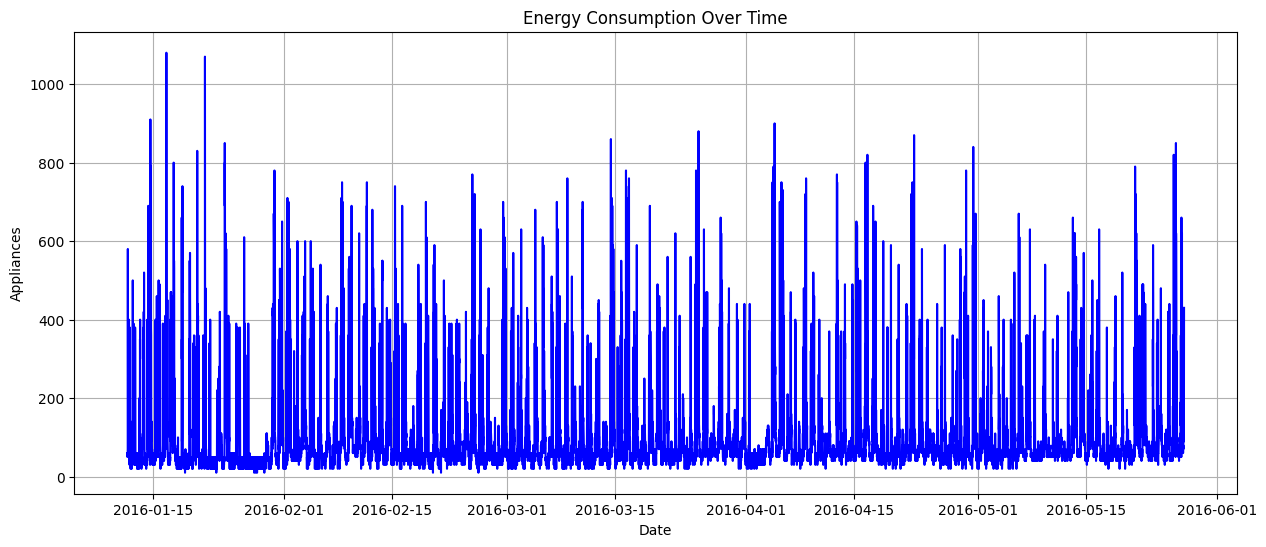

In [8]:
# 可视化数据集
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Appliances'], color='blue')
plt.title('Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Appliances')
plt.grid(True)
plt.show()

In [9]:
def SampledDataset(sample_type):
    
    if sample_type =='Hourly':
        df_sampled= df.resample('h').mean()

    elif sample_type =='Weekly':
        df_sampled= df.resample('W').mean()
        
    elif sample_type =='Daily':
        df_sampled= df.resample('D').mean()

    df_sampled.plot(kind='line',figsize=(15, 5),legend=False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(sample_type,fontsize=10,fontweight='bold')
    plt.xlabel('Date', fontsize=10,fontweight='bold') 
    plt.ylabel('Power[MW]', fontsize=10,fontweight='bold') 
    plt.show()
    return df_sampled

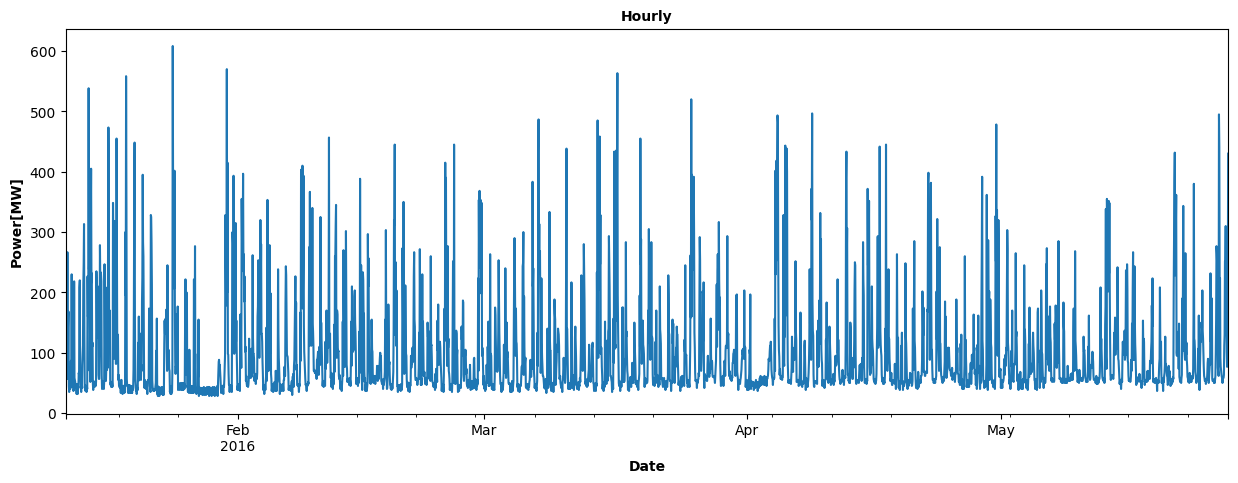

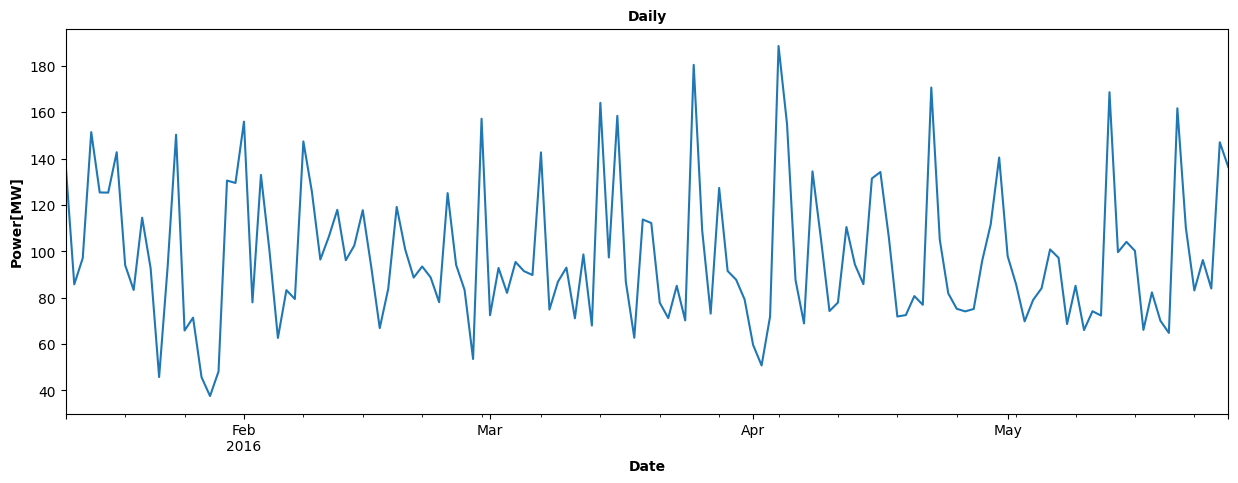

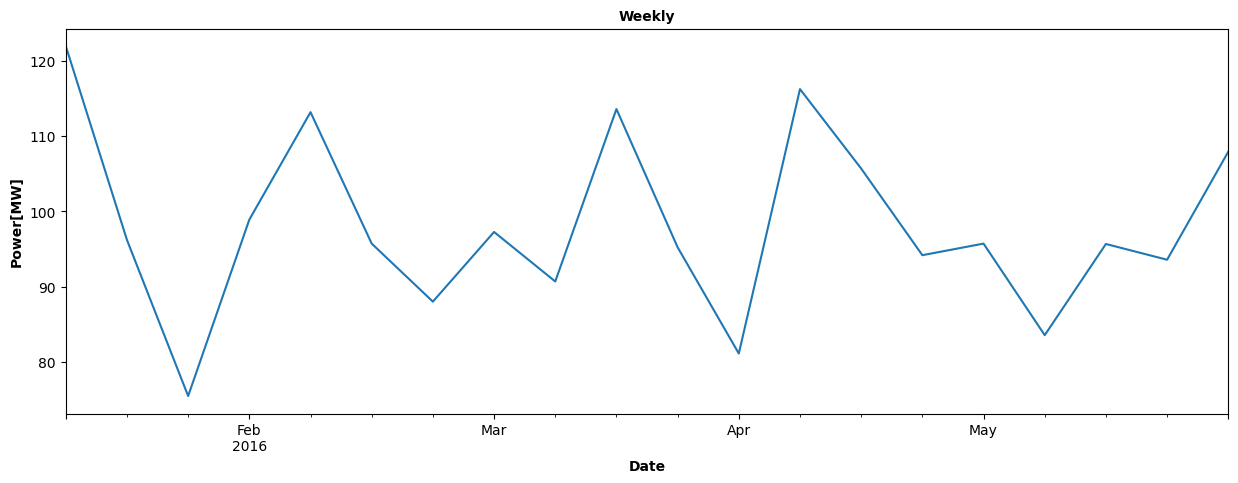

In [10]:
sample_type = 'Hourly'
df_monthly = SampledDataset(sample_type)

sample_type = 'Daily'
df_daily= SampledDataset(sample_type)

sample_type = 'Weekly'
df_weekly= SampledDataset(sample_type)

In [12]:
from statsmodels.tsa.stattools import adfuller

# defining helper functions for stationarity test
def adftest(y_series):
    #Augmented Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(y_series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)
    print("*************")

adftest(df)

Results of Dickey Fuller Test:
Test Statistic                   -21.616378
p-value                            0.000000
#Lags Used                        11.000000
Number of Observations Used    19723.000000
Critical Value (1%)               -3.430682
Critical Value (5%)               -2.861687
Critical Value (10%)              -2.566848
dtype: float64
*************


可以看出时间序列是稳定的，因为p-value<0.05


### 3. Pre-process the data

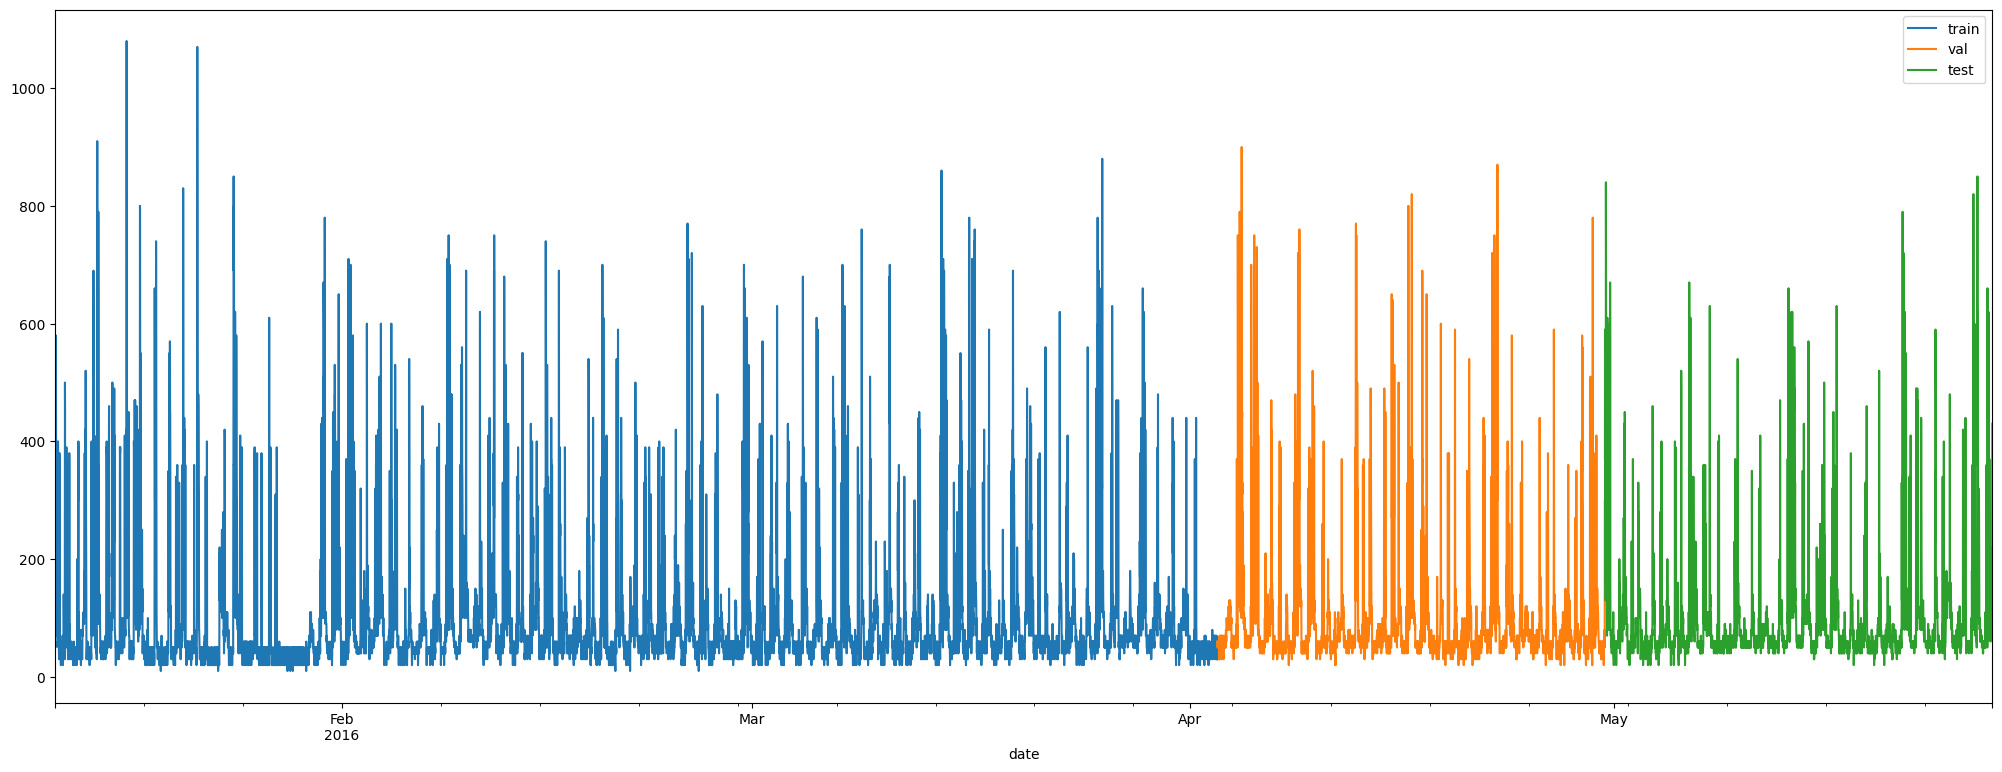

In [11]:
appliances=df[['Appliances']]

# 计算数据集长度
total_length = len(appliances)
train_ratio = 0.6  # 训练集比例
val_ratio = 0.2    # 验证集比例
test_ratio = 0.2   # 测试集比例

# 计算每个部分的长度
train_length = int(total_length * train_ratio)
val_length = int(total_length * val_ratio)
test_length = total_length - train_length - val_length

# 分割数据集
train_data = pd.DataFrame(appliances.iloc[:train_length])
val_data = pd.DataFrame(appliances.iloc[train_length:train_length + val_length])
test_data = pd.DataFrame(appliances.iloc[train_length + val_length:])

# 可视化分割后的数据集
fig = plt.figure(figsize=(25, 9))
ax = fig.add_subplot(111)
train_data.plot(ax=ax)
val_data.plot(ax=ax)
test_data.plot(ax=ax)
plt.legend(['train', 'val', 'test'])
plt.show()

### 4. Implement, train and test prediction models

#### （1）ARIMA model

In [16]:
import pmdarima as pm

search_model = pm.arima.auto_arima(train_data['Appliances'],
                                   start_p=1, start_q=1, d=1,
                                   max_p=7, max_q=7, max_d=5,
                                   max_order=None,
                                   seasonal=False,
                                   test='adf',
                                   trace=True,
                                   error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=133938.869, Time=2.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=135466.082, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=135425.610, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=135389.518, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=135464.082, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=133721.126, Time=2.73 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=134854.043, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=133713.498, Time=6.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=134602.463, Time=0.67 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=133715.379, Time=15.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=133715.382, Time=12.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=133713.453, Time=7.73 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=133711.605, Time=4.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=134275.745, Time=2.86 sec
 AR

In [17]:
p= 7
q= 1
d= 3

In [18]:
from statsmodels.tsa.arima.model import ARIMA

# 创建ARIMA模型对象并拟合模型
model = ARIMA(train_data, order=(p, d, q))
fitted_model = model.fit()

/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/stat

In [21]:
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    
    """Calculates MAPE given y_true and y_pred"""
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f'The Mean Absolute Percentage Error is: {mape:.2f}')
predcited_set = fitted_model.apply(val_data['Appliances'])
y_pred= predcited_set.fittedvalues

print('Using Validation Dataset:')
print('Mean Sqaured Error is: {:.2f}'.format(mean_squared_error(val_data['Appliances'], y_pred)))
mean_absolute_percentage_error(val_data['Appliances'],y_pred)

Using Validation Dataset:
Mean Sqaured Error is: 5737.70
The Mean Absolute Percentage Error is: 27.59


/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


In [23]:
y_test = test_data['Appliances']
forecasted_set = fitted_model.apply(y_test)
y_forecasted= forecasted_set.fittedvalues

print('Using Testing Dataset:')
print(f'Mean Squared Error is: {mean_squared_error(y_forecasted,y_test):.2f}')
mean_absolute_percentage_error(y_test,y_forecasted)

Using Testing Dataset:
Mean Squared Error is: 5120.40
The Mean Absolute Percentage Error is: 26.86


/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/yuqing/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


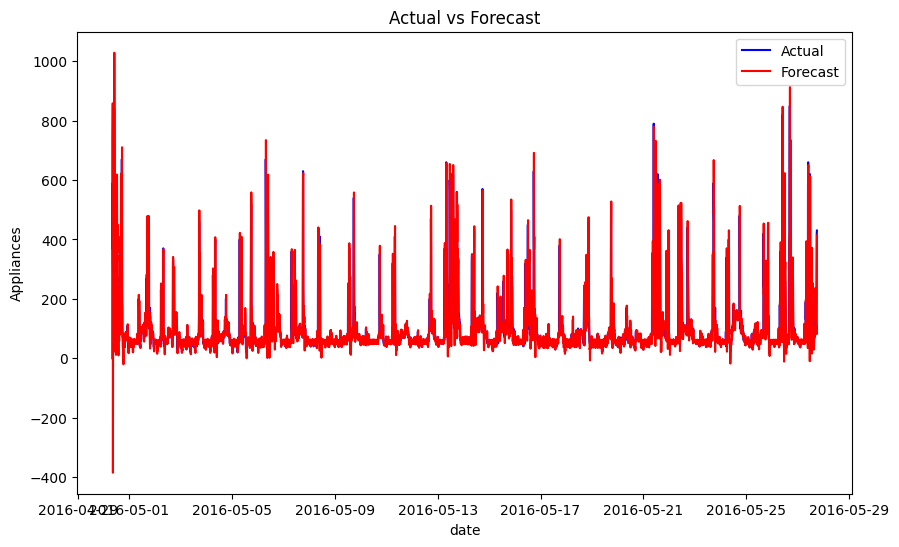

In [24]:
# 绘制预测值和实际值的对比图
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_forecasted, label='Forecast', color='red')
plt.xlabel('date')
plt.ylabel('Appliances')
plt.title('Actual vs Forecast')
plt.legend()
plt.show()

#### （1）LSTM model

In [14]:
# 对数据进行归一化

from sklearn.preprocessing import MinMaxScaler

# 创建MinMaxScaler对象
scaler = MinMaxScaler()

# 对训练集、验证集和测试集进行归一化处理
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

# 将归一化后的数据转换为DataFrame格式
train_scaled_df = pd.DataFrame(train_scaled, columns=['Scaled'], index=train_data.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=['Scaled'], index=val_data.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=['Scaled'], index=test_data.index)

In [15]:
for i in range(1, 19):
    train_scaled_df ['Scaled_{}'.format(i)]=train_scaled_df ['Scaled'].shift(i)
    val_scaled_df ['Scaled_{}'.format(i)]=val_scaled_df ['Scaled'].shift(i)
    test_scaled_df ['Scaled_{}'.format(i)]=test_scaled_df ['Scaled'].shift(i)

In [17]:
val_scaled_df

,Scaled,Scaled_1,Scaled_2,Scaled_3,Scaled_4,Scaled_5,Scaled_6,Scaled_7,Scaled_8,Scaled_9,Scaled_10,Scaled_11,Scaled_12,Scaled_13,Scaled_14,Scaled_15,Scaled_16,Scaled_17,Scaled_18
date,,,,,,,,,,,,,,,,,,,
2016-04-02 22:30:00,0.046729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-02 22:40:00,0.046729,0.046729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-02 22:50:00,0.046729,0.046729,0.046729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-02 23:00:00,0.037383,0.046729,0.046729,0.046729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-02 23:10:00,0.046729,0.037383,0.046729,0.046729,0.046729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-30 07:30:00,0.065421,0.046729,0.037383,0.037383,0.046729,0.028037,0.018692,0.009346,0.028037,0.037383,0.037383,0.046729,0.037383,0.046729,0.037383,0.046729,0.037383,0.037383,0.037383
2016-04-30 07:40:00,0.065421,0.065421,0.046729,0.037383,0.037383,0.046729,0.028037,0.018692,0.009346,0.028037,0.037383,0.037383,0.046729,0.037383,0.046729,0.037383,0.046729,0.037383,0.037383
2016-04-30 07:50:00,0.037383,0.065421,0.065421,0.046729,0.037383,0.037383,0.046729,0.028037,0.018692,0.009346,0.028037,0.037383,0.037383,0.046729,0.037383,0.046729,0.037383,0.046729,0.037383


In [18]:
x_train=train_scaled_df.dropna().drop('Scaled', axis=1)
y_train=train_scaled_df.dropna()[['Scaled']]

x_val=val_scaled_df.dropna().drop('Scaled', axis=1)
y_val=val_scaled_df.dropna()[['Scaled']]

x_test=test_scaled_df.dropna().drop('Scaled', axis=1)
y_test=test_scaled_df.dropna()[['Scaled']]

In [19]:
x_train=x_train.to_numpy()
x_test=x_test.to_numpy()
x_val=x_val.to_numpy()
 
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()
y_val=y_val.to_numpy()
 
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_val.shape)
print(y_train.shape)
print(y_test.shape)

(11823, 18)
(3929, 18)
(3929, 18)
(3929, 1)
(11823, 1)
(3929, 1)


In [26]:
x_train_t = x_train.reshape(x_train.shape[0], 18,1)
x_test_t = x_test.reshape(x_test.shape[0], 18, 1)
x_val_t = x_val.reshape(x_val.shape[0], 18, 1)

In [27]:
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
import tensorflow.keras.backend as K 
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
K.clear_session() 
# 创建一个序列模型
model = Sequential()

# 添加第一层LSTM，包含30个单元，并返回完整的输出序列，输入形状为 (18, 1)
model.add(LSTM(30, return_sequences=True, input_shape=(18, 1)))

# 添加第二层LSTM，包含42个单元，但只返回最后一个时间步的输出
model.add(LSTM(42, return_sequences=False))

# 添加一个具有1个神经元的全连接层，使用sigmoid激活函数生成输出
model.add(Dense(1, activation='sigmoid'))

# 使用均方误差损失和Adam优化器编译模型
model.compile(loss='mean_squared_error', optimizer='adam')

# 打印模型的摘要信息，包括每一层的参数数量和总体模型结构
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 42)                12264     
                                                                 
 dense (Dense)               (None, 1)                 43        
                                                                 
Total params: 16147 (63.07 KB)
Trainable params: 16147 (63.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

In [32]:
model.fit(x_train_t, y_train, epochs=50,
          batch_size=20, verbose=1, callbacks=[early_stop])
 
y_pred = model.predict(x_test_t)

Epoch 1/50


592/592 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 2/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 3/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 4/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0044
Epoch 5/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0043
Epoch 6/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 7/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 8/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 9/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 10/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 11/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 12/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 13/50
592/592 [===============

In [33]:
model.fit(x_train_t, y_train, epochs=50,
          batch_size=20, verbose=1, callbacks=[early_stop])
 
y_pred = model.predict(x_test_t)

Epoch 1/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0042
Epoch 2/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 3/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 4/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 5/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0042
Epoch 6/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 7/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 8/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0040
Epoch 9/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0040
Epoch 10/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0040
Epoch 11/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0040
Epoch 12/50
592/592 [==============================] - 2s 4ms/step - loss: 0.0040
Epoch 13/50
592/592 [====

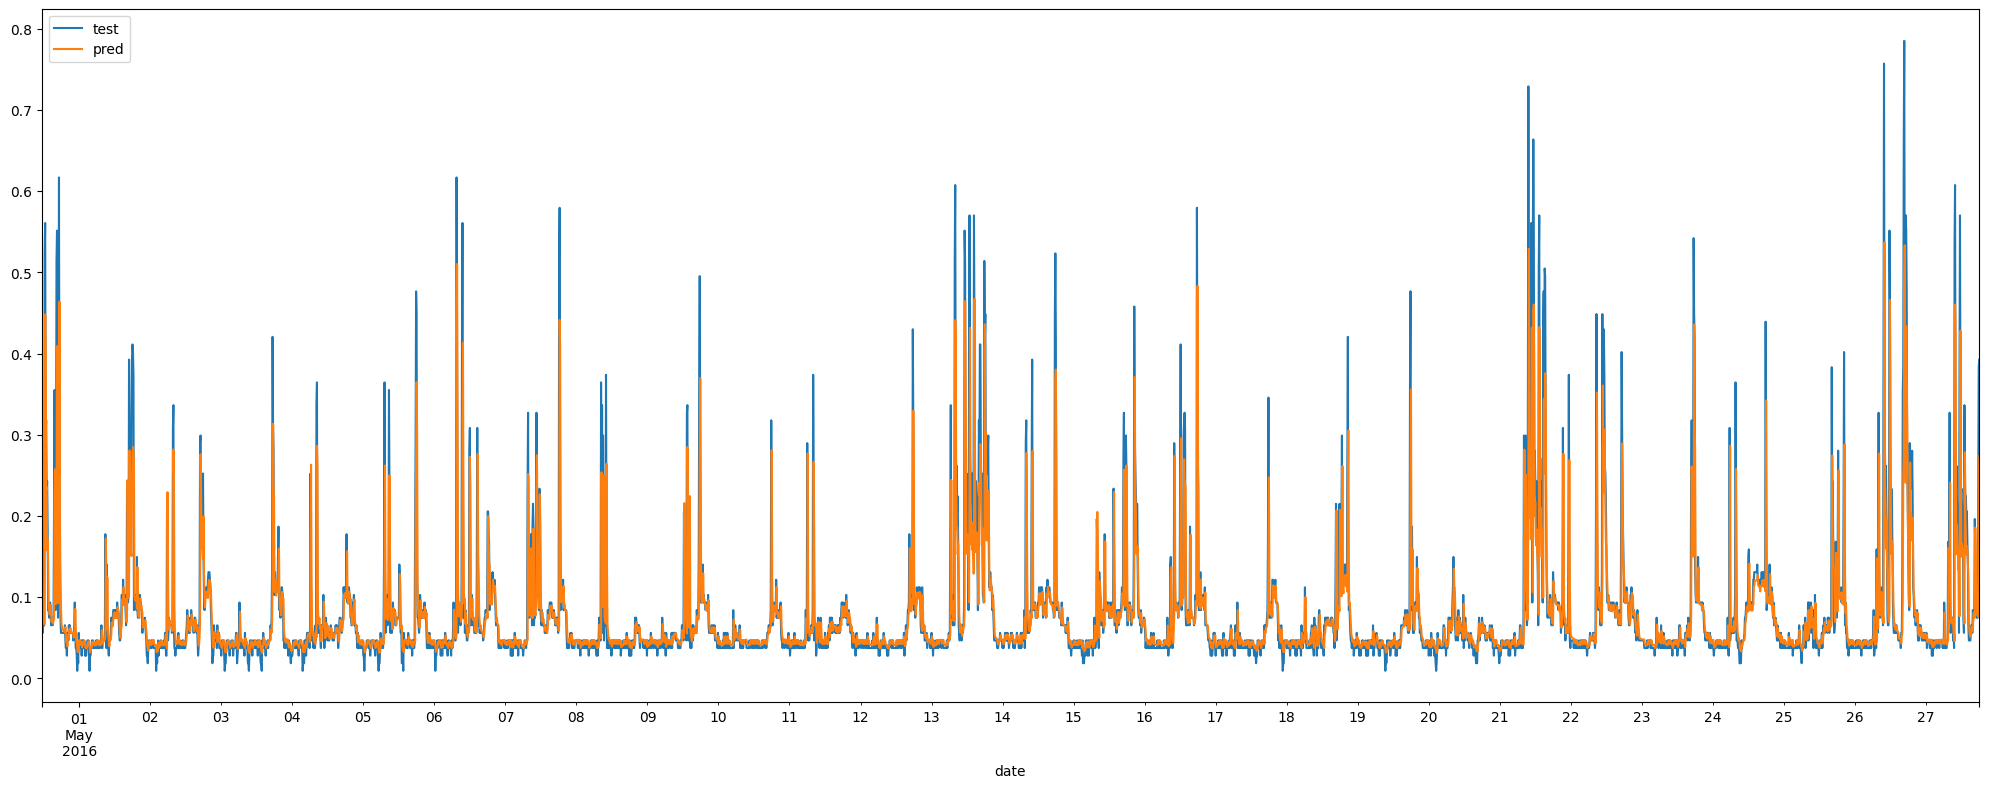

In [34]:
t_df=test_scaled_df.dropna()
y_test_df=pd.DataFrame(y_test, columns=['Appliances'], index=t_df.index)
y_pred_df=pd.DataFrame(y_pred, columns=['Appliances'], index=t_df.index)
 
 
fig = plt.figure(figsize=(25, 9))
ax1 = fig.add_subplot(111)
y_test_df.plot(ax=ax1)
y_pred_df.plot(ax=ax1)
plt.legend(['test','pred'])

### 5. Compare the results from all candidate models, choose the best model, justify your choice and discuss the results


Compare with the results you have obtained in Assignment 1a.

### 6. Reflect on what you have learned by completing this assignment and how to improve the models

### 7. References